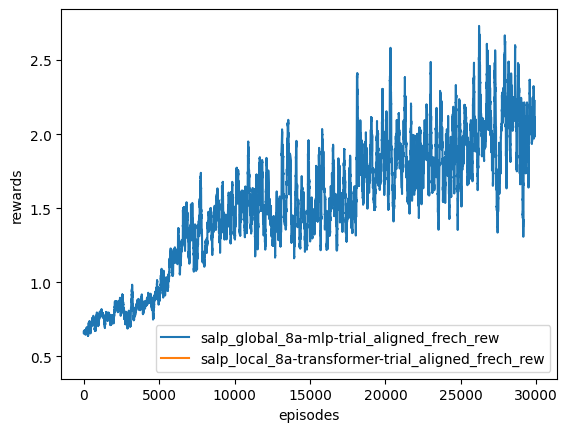

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
import csv
import numpy as np
import os
import yaml
import pickle

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def add_rolling_std(data, window_size=10):
    """Calculate standard deviation in a rolling window"""
    if len(data) <= window_size:
        return np.zeros_like(data)
    
    rolling_std = np.zeros_like(data)
    padded = np.pad(data, (window_size//2, window_size//2), mode='edge')
    
    for i in range(len(data)):
        window = padded[i:i+window_size]
        rolling_std[i] = np.std(window)
    
    return rolling_std

plotting_dir = Path().resolve()
config_dir = plotting_dir / "ppo_config.yaml"

with open(config_dir, "r") as file:
    config = yaml.safe_load(file)

data = []
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

# Use a different color for each experiment-batch combination
experiment_colors = {}
color_idx = 0

for batch in config["batches"]:
    for experiment in config["experiments"]:
        # Use a single color for all trials of the same experiment
        exp_key = f"{batch}-{experiment}"
        if exp_key not in experiment_colors:
            experiment_colors[exp_key] = plt.cm.tab10(color_idx % 10)
            color_idx += 1
        
        for trial in config["trials"]:
            checkpoint_path = Path(f"{config['base_path']}/{batch}/{experiment}/{trial}/logs/data.dat")

            if checkpoint_path.is_file():
                with open(checkpoint_path, "rb") as handle:
                    data = pickle.load(handle)[:config["datapoints"]]
                    print(f"Trial {exp_key}-{trial}: {len(data)} points")

                    # Calculate moving average
                    rewards_moving_avg = moving_average(data, config["moving_avg_window_size"])
                    
                    # Calculate rolling variance (adjust window size as needed)
                    variance_window = len(rewards_moving_avg) // 5  # 10% of data length, max 25
                    rolling_std = add_rolling_std(rewards_moving_avg, window_size=variance_window)
                    
                    # X axis for the moving average
                    x = np.arange(len(rewards_moving_avg))
                    
                    # Plot the original data with low alpha
                    # ax.plot(data, alpha=0.1, linewidth=0.5, color=experiment_colors[exp_key])
                    
                    # Plot the confidence band using rolling variance
                    ax.fill_between(
                        x, 
                        rewards_moving_avg - rolling_std,
                        rewards_moving_avg + rolling_std,
                        alpha=0.3,
                        color=experiment_colors[exp_key],
                        label=None
                    )
                    
                    # Plot the moving average line on top
                    ax.plot(
                        x, 
                        rewards_moving_avg, 
                        label=f"{exp_key}-{trial}",
                        linewidth=2,
                        color=experiment_colors[exp_key]
                    )

ax.legend(loc='best')
ax.set_xlabel("Episodes")
ax.set_ylabel("Rewards")
ax.set_title("Learning Curves with Standard Deviation")
ax.grid(True, alpha=0.3)

plt.show()